<a href="https://colab.research.google.com/github/eitellauria/Applied_Causal_Inference_Course/blob/main/ChatGPT_poll_composite_vars_analysis_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ChatGPT Poll Composite Var creation and Analysis
Modified by: EL

Things added, changed:
- Added helper class for PCA-weighted composite socre creation
- Read the ChatGPT-Clean.csv data
- Relabeled the variables for readability purposes (may still need more changes)
- Recoded Likert vars to numbers (int)
- COmpute composite scores and conbach alphas on subsets of variables.

Singleton variable are due to the fact that the cronbach-alpha coeff was below 0.7


In [1]:
#!pip install vaderSentiment --quiet
!pip install pingouin --quiet
!pip install openpyxl --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 2.5 MB/s eta 0:00:00


In [2]:
# Imports
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
#import pingouin as pg
#import researchpy as rp  # for statistical tests
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # for sentiment analysis
import warnings
warnings.filterwarnings('ignore')

## Helper class - PCA-weighted  composite score creation

In [3]:
class LikertCompositeCalculator:
    def __init__(self, data, withPCA=True):
        # Standardizing the data
        self.data = zscore(data, ddof=1)
        self.withPCA = withPCA

    def calc_ca(self):
        # Calculating Cronbach's alpha manually
        k = self.data.shape[1]
        if k > 1:
            variance_sum = self.data.var(axis=0, ddof=1).sum()
            total_variance = self.data.sum(axis=1).var(ddof=1)
            cronbach_alpha = (k / (k - 1)) * (1 - (variance_sum / total_variance))
        else:
            cronbach_alpha = 1
        return cronbach_alpha

    def calc2_ca(self):
        # Calculating Cronbach's alpha using pingouin
        if self.data.shape[1] > 1:
            cronbach_alpha = pg.cronbach_alpha(self.data)[0]
        else:
            cronbach_alpha = 1
        return cronbach_alpha

    def calc_composite_score(self):
        # Step 1: Perform PCA (data already standardized)
        pca = PCA()
        pca.fit(self.data)

        # Step 2: Calculate Weights
        if self.withPCA:
            weights = pca.components_[0] / np.sum(pca.components_[0])
        else:
            k = self.data.shape[1]
            broadcast_value = (1.0 / k)
            weights = np.full(k, broadcast_value)

        # Step 3: Calculate Composite Scores
        composite_scores = np.dot(self.data, weights)

        # Step 4: Standardize Composite Scores
        standardized_composite_scores = zscore(composite_scores)

        return standardized_composite_scores, weights


## Read in clean poll results

In [4]:
# Read in clean poll results
# I placed the file you provided in my website at Marist, was easier to load the data for me
data = pd.read_csv('https://foxweb.marist.edu/users/jf4n/Research/ChatGPTSurvey/ChatGPT-Clean.csv')

In [5]:
data.sample(20)

,Q2,Q4,Q5,Q6,Q7_1,Q7_2,Q7_3,Q8_1,Q8_2,Q8_3,...,Q15_9,Q17,Q19,Q21,Q22,Q23,sex,age,occupation/school,student/faculty
90,A good amount,From the news,To aid in completion of a project,To aid in completion of a project,Somewhat agree,Somewhat agree,Strongly agree,Somewhat agree,Somewhat agree,Strongly agree,...,Strongly agree,Somewhat agree,Strongly agree,Neither likely nor unlikely,Somewhat likely,Innovative,Male,18-21,CS & Math,Student
319,A good amount,From a family member,To obtain significant help with a project,Curiosity,Somewhat agree,Neither agree nor disagree,Somewhat agree,Strongly agree,Strongly agree,Strongly agree,...,Neither agree nor disagree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192,A good amount,From a friend,To aid in completion of a project,To obtain significant help with a project,Somewhat disagree,Somewhat agree,Somewhat agree,Somewhat disagree,Somewhat agree,Strongly agree,...,Strongly agree,Somewhat agree,Neither agree nor disagree,Somewhat likely,Somewhat likely,I believe that this tool is helpful to give su...,Female,18-21,Science,Student
283,A good amount,From a family member,To obtain significant help with a project,To get started with a project,Somewhat agree,Somewhat agree,Strongly agree,Somewhat agree,Somewhat disagree,Somewhat disagree,...,Strongly agree,Strongly agree,Strongly disagree,Somewhat likely,Neither likely nor unlikely,"My initial reaction to hearing about it was ""t...",Female,26-29,Professor/Faculty,Professor/Faculty
54,A great deal,From the news,To obtain significant help with a project,To get started with a project,Somewhat agree,Somewhat disagree,Somewhat agree,Somewhat agree,Somewhat disagree,Somewhat agree,...,Somewhat agree,Strongly agree,Strongly agree,Somewhat likely,Somewhat unlikely,NaN,Female,18-21,CS & Math,Student
351,Nothing at all,None,To aid in completion of a project,To aid in completion of a project,Strongly agree,Neither agree nor disagree,Strongly agree,Somewhat agree,Neither agree nor disagree,Neither agree nor disagree,...,Neither agree nor disagree,Somewhat agree,Strongly disagree,Very unlikely,Very unlikely,Not sure why one would use ChatGPT when you ca...,Female,46+,Management,Student
217,A good amount,From the news,To obtain significant help with a project,Other; please specify,Strongly agree,Somewhat agree,Strongly agree,Strongly agree,Somewhat agree,Strongly agree,...,Strongly agree,Strongly agree,Strongly disagree,Somewhat likely,Somewhat unlikely,It's a tool like others that can be useful but...,Male,42-45,Professor/Faculty,Professor/Faculty
89,A great deal,From a friend,To obtain significant help with a project,To obtain significant help with a project,Strongly agree,Somewhat agree,Strongly disagree,Strongly agree,Strongly agree,Strongly agree,...,Somewhat agree,Strongly agree,Somewhat agree,Very likely,Neither likely nor unlikely,I think ChatGPT is a great thing for people wh...,Male,18-21,CS & Math,Student
190,A great deal,From the news,To obtain significant help with a project,To obtain significant help with a project,Somewhat agree,Strongly agree,Strongly agree,Somewhat agree,Somewhat disagree,Somewhat disagree,...,Strongly agree,Somewhat agree,Neither agree nor disagree,Somewhat unlikely,Somewhat unlikely,"Unless you give it very specific prompts, thro...",Female,46+,Professor/Faculty,Professor/Faculty
227,A great deal,From the news,Other; please specify,Other; please specify,Neither agree nor disagree,Neither agree nor disagree,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,...,Somewhat agree,Neither agree nor disagree,Strongly disagree,Neither likely nor unlikely,Very unlikely,This is another new technology that will be pa...,Female,46+,Professor/Faculty,Professor/Faculty


In [6]:
#data.info()

In [7]:
new_column_names = {'Q2':    'Q2_AWARENESS',
                    'Q4':    'SOURCE',
                    'Q5':    'Q5_REASON_STUDENT',
                    'Q6':    'Q6_REASON_PROF',
                    'Q7_1':  'Q71_BENEFITS',
                    'Q7_2':  'Q72_LIMITATIONS',
                    'Q7_3':  'Q73_IMPLICATIONS',
                    'Q8_1':  'Q81_LIKELY_PRODUCTIVE',
                    'Q8_2':  'Q82_PRODUCTIVE_STUDENT',
                    'Q8_3':  'Q83_PRODUCTIVE_PROF',
                    'Q8_4':  'Q84_PRODUCTIVE_PERSON',
                    'Q9_1':  'Q91_PLAG_STUDENT',
                    'Q9_2':  'Q92_PLAG_PROF',
                    'Q9_3':  'Q93_PLAG_PERSON',
                    'Q9_4':  'Q94_CAUGHT_PLAG',
                    'Q10':   'Q10_SOC_IMPACT',
                    'Q11':   'Q11_HIGHERED_BENEFIT',
                    'Q12':   'Q12_RESP_USE',
                    'Q13':   'Q13_FREQ_USE',
                    'Q14':   'Q14_RESP_REASON_USE',
                    'Q15_1': 'Q151_RESP_WILL_USE',
                    'Q15_2': 'Q152_RESP_BENEFIT',
                    'Q15_3': 'Q153_RESP_PRODUCTIVE',
                    'Q15_4': 'Q154_RESP_FEEL_PLAG',
                    'Q15_5': 'Q155_RESP_TRUST_OUTPUT',
                    'Q15_6': 'Q156_RESP_USE_OUTPUT',
                    'Q15_7': 'Q157_RESP_WILL_PLAG',
                    'Q15_8': 'Q158_RESP_PRODUCTIVE',
                    'Q15_9': 'Q159_RESP_IMPACTED',
                    'Q17':   'Q17_ACCURATE_OUTPUT_DELIVERY',
                    'Q19':   'Q19_ACCURATE_OUTPUT_COUNTRY',
                    'Q21':   'Q21_TRUST_OUTPUT_COAT',
                    'Q22':   'Q22_USE_OUTPUT_COAT',
                    'Q23':   'Q23_THOUGHTS',
                    'sex':   'GENDER',
                    'age':   'AGE_RANGE',
                    'occupation/school': 'OCCUP_SCHOOL',
                    'student/faculty':   'OCCUPATION'

					}

In [8]:
df = data.rename(columns=new_column_names)
#df.info()

In [9]:
df.groupby('AGE_RANGE').count()['SOURCE']

AGE_RANGE
18-21    180
22-25     50
26-29     14
30-33     11
34-37      7
38-41     17
42-45     13
46+       63
Name: SOURCE, dtype: int64

## Check missing values

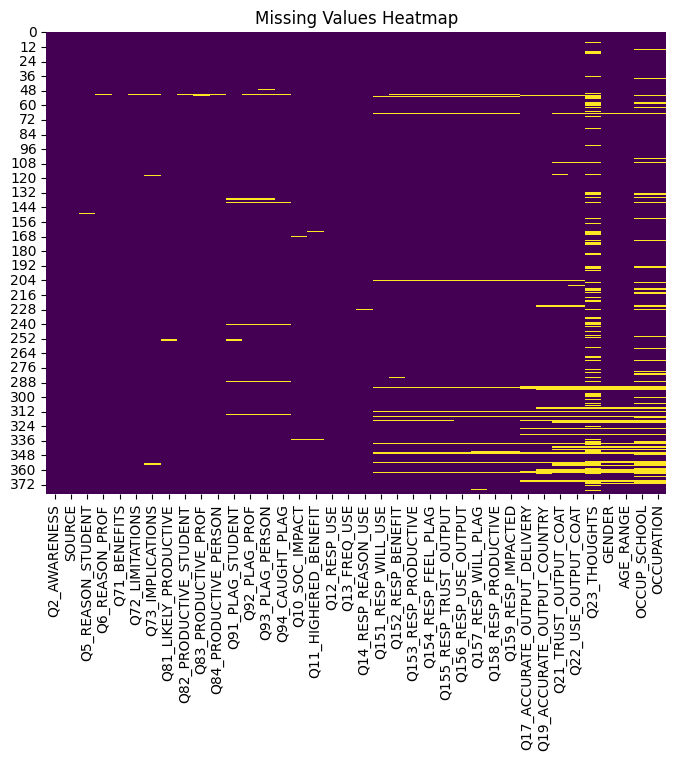

In [10]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

## Remove nulls, recode and drop Q23-THOUGHTS

In [11]:
df1 = df.drop("Q23_THOUGHTS", axis=1).dropna()
df1['OCCUPATION'] = df1['OCCUPATION'].replace('Professor/Faculty', 'Instructor')
#--------------------------
df1['GENDER'] = df1['GENDER'].replace('Non-binary / third gender', 'NB3')
df1['GENDER'] = df1['GENDER'].replace('Prefer not to say', 'PNTS')
#-----------------------------------------------------------------
df1['SOURCE'] = df1['SOURCE'].replace('From a colleague', 'colleague')
df1['SOURCE'] = df1['SOURCE'].replace('From a family member', 'familymember')
df1['SOURCE'] = df1['SOURCE'].replace('From a family member', 'familymember')
df1['SOURCE'] = df1['SOURCE'].replace('From a family member', 'familymember')
df1['SOURCE'] = df1['SOURCE'].replace('From the news', 'news')
df1['SOURCE'] = df1['SOURCE'].replace('From this questionnaire', 'questionnaire')
df1['SOURCE'] = df1['SOURCE'].replace('None', 'none')
#---------------------------------------------------------
def recode_age_range(age_range):
    if age_range in ['18-21']:
        return '18-21'
    elif age_range in ['22-25', '26-29']:
        return '22-29'
    elif age_range in ['30-33', '34-37', '38-41']:
        return '30-41'
    elif age_range in ['42-45']:
        return '42-45'
    elif age_range in ['46+']:
        return '46+'
    else:
        return age_range

# Apply the function to the AGE_RANGE column
df1['AGE_RANGE']=df['AGE_RANGE'].apply(recode_age_range)
#---------------------------------------------------------
print(df1.shape[0])
#df1["OCCUPATION"].sample(20)

302


In [12]:
#counts = df1.groupby('OCCUPATION').count()['SOURCE']
#percentages = (counts / total) * 100
#pd.concat([counts, percentages], axis=1)

In [13]:
counts = df1.groupby('AGE_RANGE').count()

total = df1['SOURCE'].count()
percentages = (counts / total) * 100

result = pd.concat([counts, percentages], axis=1)
#result.columns = ['Count', 'Percentage']

result

,Q2_AWARENESS,SOURCE,Q5_REASON_STUDENT,Q6_REASON_PROF,Q71_BENEFITS,Q72_LIMITATIONS,Q73_IMPLICATIONS,Q81_LIKELY_PRODUCTIVE,Q82_PRODUCTIVE_STUDENT,Q83_PRODUCTIVE_PROF,...,Q157_RESP_WILL_PLAG,Q158_RESP_PRODUCTIVE,Q159_RESP_IMPACTED,Q17_ACCURATE_OUTPUT_DELIVERY,Q19_ACCURATE_OUTPUT_COUNTRY,Q21_TRUST_OUTPUT_COAT,Q22_USE_OUTPUT_COAT,GENDER,OCCUP_SCHOOL,OCCUPATION
AGE_RANGE,,,,,,,,,,,,,,,,,,,,,
18-21,160,160,160,160,160,160,160,160,160,160,...,52.980132,52.980132,52.980132,52.980132,52.980132,52.980132,52.980132,52.980132,52.980132,52.980132
22-29,50,50,50,50,50,50,50,50,50,50,...,16.556291,16.556291,16.556291,16.556291,16.556291,16.556291,16.556291,16.556291,16.556291,16.556291
30-41,27,27,27,27,27,27,27,27,27,27,...,8.940397,8.940397,8.940397,8.940397,8.940397,8.940397,8.940397,8.940397,8.940397,8.940397
42-45,10,10,10,10,10,10,10,10,10,10,...,3.311258,3.311258,3.311258,3.311258,3.311258,3.311258,3.311258,3.311258,3.311258,3.311258
46+,55,55,55,55,55,55,55,55,55,55,...,18.211921,18.211921,18.211921,18.211921,18.211921,18.211921,18.211921,18.211921,18.211921,18.211921


## Plot  the distribution by demographic vars

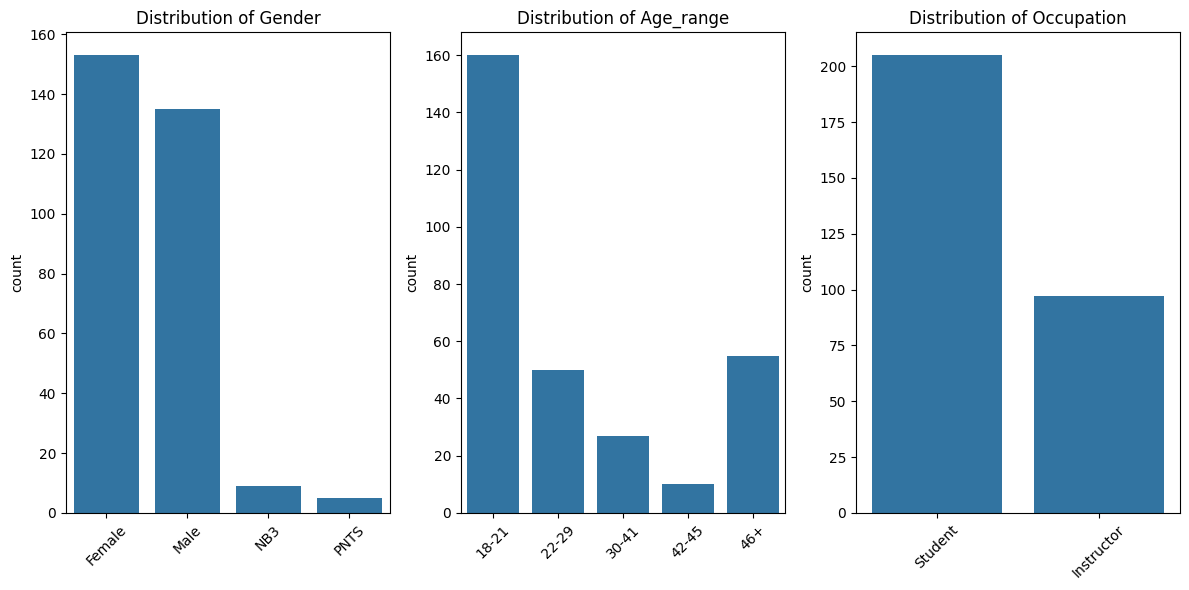

In [14]:
# Dictionary of demographic features and their categories
demog_features = {
    'GENDER': ['Female', 'Male', 'NB3', 'PNTS'],
    'AGE_RANGE': ['18-21', '22-29', '30-41', '42-45', '46+'],
    'OCCUPATION': ['Student', 'Instructor']
}

# Set up the 1x3 plot grid
fig, axes = plt.subplots(nrows=1, ncols=len(demog_features), figsize=(12, 6))

# Loop through each demog_feature and create a count plot
for i, column in enumerate(demog_features):
    sns.countplot(x=column, data=df1, ax=axes[i], order=demog_features[column])
    axes[i].set_title(f'Distribution of {column.capitalize()}')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel(None)  # Remove xlabel, if needed

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


## Recoding of Likert vars

In [15]:
##Likert (1-3) vars ----------------------------------------------------------------
likert3_mapping1 = {'Very much so':1,
                   'Somewhat':2,
                   'Not at all':3}
df1['Q10_SOC_IMPACT'] = df1['Q10_SOC_IMPACT'].map(likert3_mapping1)
df1['Q11_HIGHERED_BENEFIT'] = df1['Q11_HIGHERED_BENEFIT'].map(likert3_mapping1)

##Likert (1-4) vars ---------------------------------------------------------------
likert4_mapping1 = {'A great deal':1,
                   'A good amount':2,
                   'A little':1,
                   'Nothing at all':4}

df1['Q2_AWARENESS'] = df1['Q2_AWARENESS'].map(likert4_mapping1)


likert4_mapping2 = {'Quite a lot':1,
                   'A good amount':2,
                   'A little':1,
                   'Not at all':4}

df1['Q12_RESP_USE'] = df1['Q12_RESP_USE'].map(likert4_mapping2)


likert4_mapping3 = {'11 or more times':1,
                    '6 to 10':2,
                    '1 to 5':3,
                    '0':4}

df1['Q13_FREQ_USE'] = df1['Q13_FREQ_USE'].map(likert4_mapping3)

##Likert (1-5) vars -----------------------------------------------
likert5_mapping1 = {'Strongly agree':1,
                  'Somewhat agree':2,
                  'Neither agree nor disagree':3,
                  'Somewhat disagree':4,
                  'Strongly disagree':5}

inverse_likert5_mapping1 = {'Strongly agree':5,
                           'Somewhat agree':4,
                           'Neither agree nor disagree':3,
                           'Somewhat disagree':2,
                           'Strongly disagree':1}

for colname  in ['Q71_BENEFITS','Q72_LIMITATIONS','Q73_IMPLICATIONS',
                'Q81_LIKELY_PRODUCTIVE','Q82_PRODUCTIVE_STUDENT','Q83_PRODUCTIVE_PROF','Q84_PRODUCTIVE_PERSON',
                'Q91_PLAG_STUDENT','Q92_PLAG_PROF','Q93_PLAG_PERSON','Q94_CAUGHT_PLAG',
                'Q151_RESP_WILL_USE','Q152_RESP_BENEFIT','Q153_RESP_PRODUCTIVE','Q154_RESP_FEEL_PLAG',
                'Q155_RESP_TRUST_OUTPUT','Q156_RESP_USE_OUTPUT','Q157_RESP_WILL_PLAG','Q158_RESP_PRODUCTIVE','Q159_RESP_IMPACTED',
                'Q17_ACCURATE_OUTPUT_DELIVERY','Q19_ACCURATE_OUTPUT_COUNTRY'] :

     #keep direction (1-5)
     if colname in ['Q71_BENEFITS', 'Q72_LIMITATIONS','Q73_IMPLICATIONS',
                    'Q81_LIKELY_PRODUCTIVE','Q82_PRODUCTIVE_STUDENT','Q83_PRODUCTIVE_PROF','Q84_PRODUCTIVE_PERSON',
                    'Q91_PLAG_STUDENT','Q92_PLAG_PROF','Q93_PLAG_PERSON',
                    'Q151_RESP_WILL_USE','Q152_RESP_BENEFIT','Q153_RESP_PRODUCTIVE',
                    'Q155_RESP_TRUST_OUTPUT','Q156_RESP_USE_OUTPUT','Q158_RESP_PRODUCTIVE','Q159_RESP_IMPACTED',
                    'Q17_ACCURATE_OUTPUT_DELIVERY','Q19_ACCURATE_OUTPUT_COUNTRY']:
        df1[colname] = df1[colname].map(likert5_mapping1)
     else:
        df1[colname] = df1[colname].map(inverse_likert5_mapping1)


likert5_mapping2 = {'To obtain significant help with a project':1,
                    'To aid in completion of a project':2,
                    'To get started with a project':3,
                    'Curiosity':4,
                    'I have not used ChatGPT':5}
df1['Q14_RESP_REASON_USE'] = df1['Q14_RESP_REASON_USE'].map(likert5_mapping2)

likert5_mapping3 = {'Very likely':1,
                    'Somewhat likely':2,
                    'Neither likely nor unlikely':3,
                    'Somewhat unlikely':4,
                    'Very unlikely':5}
df1['Q21_TRUST_OUTPUT_COAT'] = df1['Q21_TRUST_OUTPUT_COAT'].map(likert5_mapping3)
df1['Q22_USE_OUTPUT_COAT'] = df1['Q22_USE_OUTPUT_COAT'].map(likert5_mapping3)


likert5_mapping4 = {'To obtain significant help with a project':1,
                    'To aid in completion of a project':2,
                    'To get started with a project':3,
                    'Curiosity':4,
                    'Other; please specify':5}
df1['Q5_REASON_STUDENT'] = df1['Q5_REASON_STUDENT'].map(likert5_mapping4)
df1['Q6_REASON_PROF'] = df1['Q6_REASON_PROF'].map(likert5_mapping4)


## Now we create subsets, compute reliability and create composites
Thisa section ends with the creation of an  Excel file.

In [16]:
# Example usage
subset_dict = {
    'AWARENESS': ['Q2_AWARENESS'],
    'REASON_STUDENT': ['Q5_REASON_STUDENT'],
    'REASON_PROFESSIONAL': ['Q6_REASON_PROF'],
    'BENEFITS': ['Q71_BENEFITS'],
    'LIMITATIONS': ['Q72_LIMITATIONS'],
    'IMPLICATIONS': ['Q73_IMPLICATIONS'],
    'WORK_PRODUCTIVITY': ['Q81_LIKELY_PRODUCTIVE','Q82_PRODUCTIVE_STUDENT','Q83_PRODUCTIVE_PROF','Q84_PRODUCTIVE_PERSON'],
    'PLAGIARISM': ['Q91_PLAG_STUDENT','Q92_PLAG_PROF','Q93_PLAG_PERSON'],
    'SOCIAL_IMPACT': ['Q10_SOC_IMPACT'],
    'HIGHERED_BENEFIT': ['Q11_HIGHERED_BENEFIT'],
    'USAGE': ['Q12_RESP_USE','Q13_FREQ_USE','Q14_RESP_REASON_USE'],
    'RESP_USE_TRUST_BENEF': ['Q151_RESP_WILL_USE','Q152_RESP_BENEFIT','Q153_RESP_PRODUCTIVE','Q154_RESP_FEEL_PLAG',
                              'Q155_RESP_TRUST_OUTPUT','Q156_RESP_USE_OUTPUT','Q157_RESP_WILL_PLAG','Q158_RESP_PRODUCTIVE','Q159_RESP_IMPACTED'],
    'ACCURACY': ['Q17_ACCURATE_OUTPUT_DELIVERY','Q19_ACCURATE_OUTPUT_COUNTRY'],
    'TRUST': ['Q21_TRUST_OUTPUT_COAT','Q22_USE_OUTPUT_COAT']
}
composite_info = []
df2 = pd.DataFrame()

for subset_name, subset_variables in subset_dict.items():
        subset = df1[subset_variables]
        lcc = LikertCompositeCalculator(subset,withPCA=True)

        # Add the composite variable to the original DataFrame
        composite_var_name = subset_name
        composite_score, weights = lcc.calc_composite_score()
        df2[composite_var_name] = composite_score

        # Calculate Cronbach's alpha
        cronbach_alpha = lcc.calc_ca()
        #print(subset_name,list(zip(subset_variables,weights)),lcc.calc_ca(),'\n' )

        # Add information to the composite info list
        composite_info.append({'SubsetName': subset_name,'subset': list(zip(subset_variables,weights)), 'CronbachAlpha': cronbach_alpha})

# Create a new df, augmented with the composites
result_df = pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True)], axis=1)

# Create a DataFrame to store composite information
composite_info_df = pd.DataFrame(composite_info)


In [17]:
composite_info_df['subset'][6]

[('Q81_LIKELY_PRODUCTIVE', 0.2695951460824908),
 ('Q82_PRODUCTIVE_STUDENT', 0.26392241664318844),
 ('Q83_PRODUCTIVE_PROF', 0.2783267451215751),
 ('Q84_PRODUCTIVE_PERSON', 0.18815569215274552)]

In [18]:
result_df

,Q2_AWARENESS,SOURCE,Q5_REASON_STUDENT,Q6_REASON_PROF,Q71_BENEFITS,Q72_LIMITATIONS,Q73_IMPLICATIONS,Q81_LIKELY_PRODUCTIVE,Q82_PRODUCTIVE_STUDENT,Q83_PRODUCTIVE_PROF,...,LIMITATIONS,IMPLICATIONS,WORK_PRODUCTIVITY,PLAGIARISM,SOCIAL_IMPACT,HIGHERED_BENEFIT,USAGE,RESP_USE_TRUST_BENEF,ACCURACY,TRUST
0,1,news,1,2,4,4,4,3,3,3,...,2.175334,2.377914,0.937114,-1.743006,0.971289,1.710593,0.986605,1.999262,0.343835,1.945316
1,2,news,3,2,1,1,1,1,2,1,...,-1.024102,-0.823260,-0.958130,-0.087859,-0.909027,-1.151452,-0.827791,-0.711531,-0.400275,-0.762243
2,2,From a friend,3,3,1,2,2,1,2,2,...,0.042377,0.243798,-0.780467,-0.749158,0.971289,-1.151452,-0.744877,-0.991761,-1.383427,-0.762243
3,1,familymember,2,2,1,1,1,2,2,2,...,-1.024102,-0.823260,-0.395364,-0.485240,0.971289,0.279571,-1.449064,-0.917453,-0.147741,-0.762243
4,4,From a friend,4,1,1,2,2,1,3,1,...,0.042377,0.243798,-0.188417,0.951111,-0.909027,-1.151452,0.986605,-0.817471,0.091301,-1.248278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,1,news,1,3,1,1,1,2,2,2,...,-1.024102,-0.823260,-0.162520,-0.442019,0.971289,0.279571,-1.710045,-0.613275,-0.400275,1.459281
298,2,news,1,4,3,1,1,3,5,4,...,-1.024102,-0.823260,1.722827,-1.103318,0.971289,0.279571,-0.827791,0.882178,2.576164,1.945316
299,2,familymember,2,2,1,2,1,2,4,4,...,0.042377,-0.823260,1.266544,-0.440119,-0.909027,0.279571,0.986605,1.269497,0.343835,0.070727
300,1,news,2,4,1,3,5,1,1,1,...,1.108856,3.444972,-1.727843,-0.440119,0.971289,-1.151452,0.986605,-0.862288,-0.400275,-0.345758


In [19]:
#result_df.to_csv('coded_data.csv', index=False)
#composite_info_df.to_csv('composite_info_df', index=False)

In [20]:
import os
excel_filename = 'pollcodeddata.xlsx'
if os.path.exists(excel_filename):
    os.remove(excel_filename)

# Create an ExcelWriter object
with pd.ExcelWriter(excel_filename) as writer:
    # Write each DataFrame to a different worksheet
    result_df.to_excel(writer, sheet_name='coded_data', index=False)
    composite_info_df.to_excel(writer, sheet_name='composite_info', index=False)

#Remove comment if you want to download Excel file
#from google.colab import files
#files.download('pollcodeddata.xlsx')

___________________________________________
# Create bar charts

In [21]:
def  create_bar_graphs(categorical_var_name,categorical_var_ordered_values, variables, num_rows, num_cols, figsize=(16, 12)):

  # Create a list of categorical variables
  # You can replace this with your actual categorical variable data
  categorical_var = result_df[categorical_var_name]
  cat_codes = categorical_var_ordered_values  # Unique categorical codes


  # Create a figure and axes for the subplots
  fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
  fig.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing between subplots

  # Loop over each variable and subplot
  for i, variable in enumerate(variables):
    row = i // num_cols
    col = i % num_cols

    ax = axes[row, col]

    # Replace this with your actual data
    # Generate mock data for demonstration
    data = result_df[variable]

    # Create the bar plot
    sns.barplot(x=categorical_var, y=data, ax=ax)

    # Set the xticks and labels
    ax.set_xticks(np.arange(len(categorical_var.unique())))
    ax.set_xticklabels(np.arange(len(categorical_var.unique())))

    # Set the title of the subplot
    ax.set_title(variable)
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Set the legend
    #ax.legend([variable], loc='upper left')

  # Remove any unused subplots
  for i in range(len(variables), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

  # Create code-description pairs
  code_desc_pairs = [f"{code}:{desc}" for code, desc in zip(np.arange(len(categorical_var.unique())),cat_codes)]
  bottom_legend = categorical_var_name +'. '+', '.join(code_desc_pairs)

  # Add code-description text at the bottom of the grid
  fig.text(0.1, -0.02, bottom_legend,fontsize = 11, ha='left')

  # Show the plots
  plt.tight_layout()
  plt.show()

In [22]:
variables = ['AWARENESS', 'BENEFITS', 'LIMITATIONS', 'IMPLICATIONS',
             'WORK_PRODUCTIVITY', 'PLAGIARISM', 'SOCIAL_IMPACT',
             'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST']
result_df[variables].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AWARENESS,302.0,-9.411162e-17,1.00166,-0.755298,-0.755298,-0.755298,0.330892,2.503273
BENEFITS,302.0,9.411162e-17,1.00166,-0.917109,-0.917109,0.128049,0.128049,3.263523
LIMITATIONS,302.0,-5.881976e-17,1.00166,-1.024102,-1.024102,0.042377,1.108856,3.241813
IMPLICATIONS,302.0,-1.176395e-17,1.00166,-0.823260,-0.823260,-0.823260,0.243798,3.444972
WORK_PRODUCTIVITY,302.0,-3.529186e-17,1.00166,-1.727843,-0.597834,0.002441,0.552012,3.602071
PLAGIARISM,302.0,-4.705581e-17,1.00166,-1.743006,-0.749158,-0.075153,0.551830,2.232388
SOCIAL_IMPACT,302.0,-5.881976e-18,1.00166,-0.909027,-0.909027,-0.909027,0.971289,2.851605
HIGHERED_BENEFIT,302.0,1.176395e-17,1.00166,-1.151452,-1.151452,0.279571,0.279571,1.710593
USAGE,302.0,0.000000e+00,1.00166,-2.020682,-0.823633,-0.434241,0.986605,0.986605
RESP_USE_TRUST_BENEF,302.0,0.000000e+00,1.00166,-1.763487,-0.820199,-0.056379,0.653271,2.417526


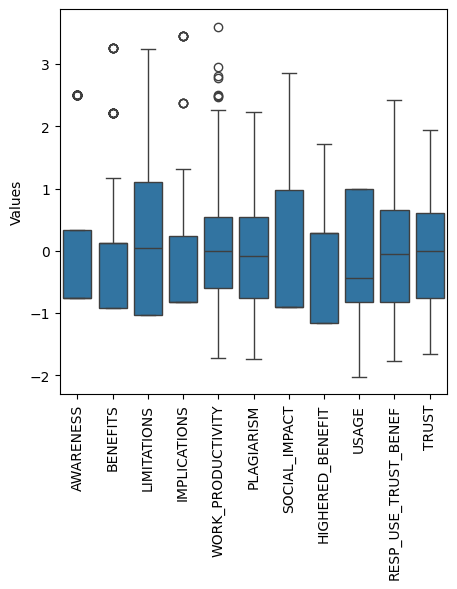

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame
variables = ['AWARENESS', 'BENEFITS', 'LIMITATIONS', 'IMPLICATIONS',
             'WORK_PRODUCTIVITY', 'PLAGIARISM', 'SOCIAL_IMPACT',
             'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST']

# Creating a long-form DataFrame suitable for seaborn
long_df = result_df.melt(value_vars=variables)

# Creating the boxplot
plt.figure(figsize=(5,5))  # Adjust the figure size as needed
sns.boxplot(x='variable', y='value', data=long_df)

# Setting titles and rotating them
plt.xticks(rotation=90)  # Rotate x-axis labels to 90 degrees
plt.xlabel('')
plt.ylabel('Values')
plt.title('')

plt.show()



In [24]:
# Assuming result_df is your DataFrame
variables = ['AWARENESS', 'BENEFITS', 'LIMITATIONS', 'IMPLICATIONS',
             'WORK_PRODUCTIVITY', 'PLAGIARISM', 'SOCIAL_IMPACT',
             'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST']

# Calculate the correlation matrix
corr_matrix = result_df[variables].corr()
corr_matrix

,AWARENESS,BENEFITS,LIMITATIONS,IMPLICATIONS,WORK_PRODUCTIVITY,PLAGIARISM,SOCIAL_IMPACT,HIGHERED_BENEFIT,USAGE,RESP_USE_TRUST_BENEF,TRUST
AWARENESS,1.000000,0.149342,0.147080,0.084356,0.020844,-0.042817,0.057327,0.190572,0.296615,0.124572,-0.086847
BENEFITS,0.149342,1.000000,0.156971,-0.064454,0.596935,-0.256003,0.155444,0.484210,0.475996,0.663466,0.312405
LIMITATIONS,0.147080,0.156971,1.000000,0.392865,-0.059614,0.098167,-0.041160,0.058902,0.167114,-0.003724,-0.150837
IMPLICATIONS,0.084356,-0.064454,0.392865,1.000000,-0.251031,0.227977,-0.044130,-0.098496,-0.114057,-0.208480,-0.261818
WORK_PRODUCTIVITY,0.020844,0.596935,-0.059614,-0.251031,1.000000,-0.260006,0.151760,0.524470,0.398996,0.705859,0.355413
PLAGIARISM,-0.042817,-0.256003,0.098167,0.227977,-0.260006,1.000000,0.003101,-0.157379,-0.242279,-0.362684,-0.230156
SOCIAL_IMPACT,0.057327,0.155444,-0.041160,-0.044130,0.151760,0.003101,1.000000,0.245227,0.137534,0.238820,0.204412
HIGHERED_BENEFIT,0.190572,0.484210,0.058902,-0.098496,0.524470,-0.157379,0.245227,1.000000,0.337210,0.567257,0.295026
USAGE,0.296615,0.475996,0.167114,-0.114057,0.398996,-0.242279,0.137534,0.337210,1.000000,0.587017,0.174299
RESP_USE_TRUST_BENEF,0.124572,0.663466,-0.003724,-0.208480,0.705859,-0.362684,0.238820,0.567257,0.587017,1.000000,0.484365


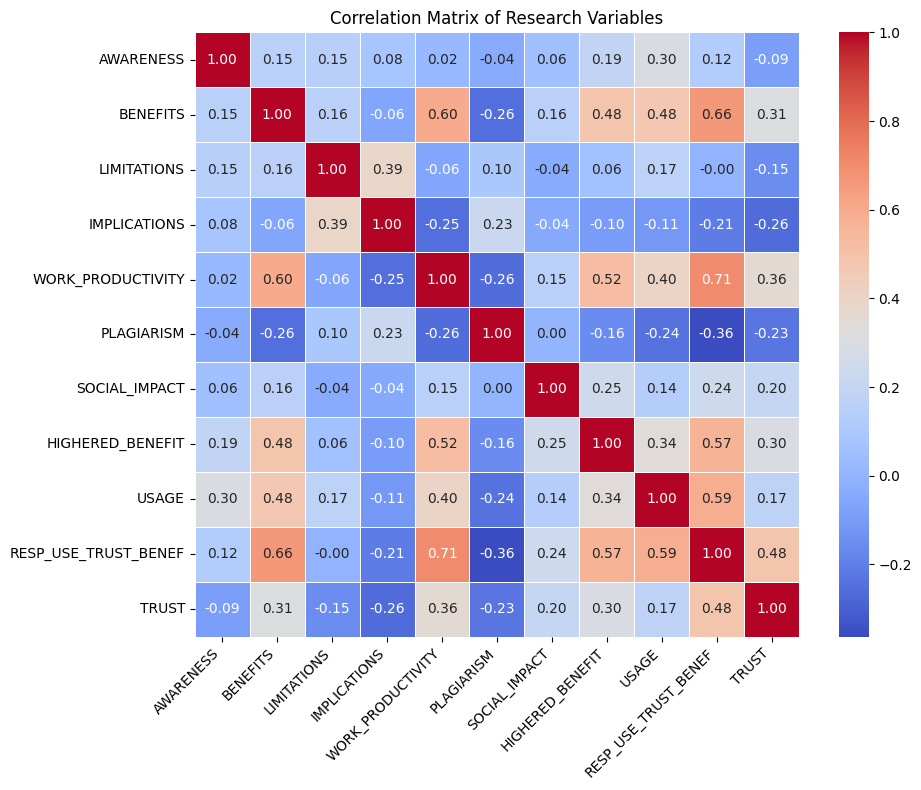

In [25]:
# Assuming result_df is your DataFrame
variables = ['AWARENESS', 'BENEFITS', 'LIMITATIONS', 'IMPLICATIONS',
             'WORK_PRODUCTIVITY', 'PLAGIARISM', 'SOCIAL_IMPACT',
             'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST']

# Calculate the correlation matrix
corr_matrix = result_df[variables].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the size as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            cbar=True, square=True, linewidths=.5)

# Customizations for a journal paper: title, labels, etc.
plt.title('Correlation Matrix of Research Variables')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.yticks(rotation=0)  # Keep y labels horizontal

# Save the figure
plt.tight_layout()  # Adjusts the plot to fit into the figure area.
#plt.savefig('correlation_matrix.png', dpi=300)  # Save as high-res image

plt.show()


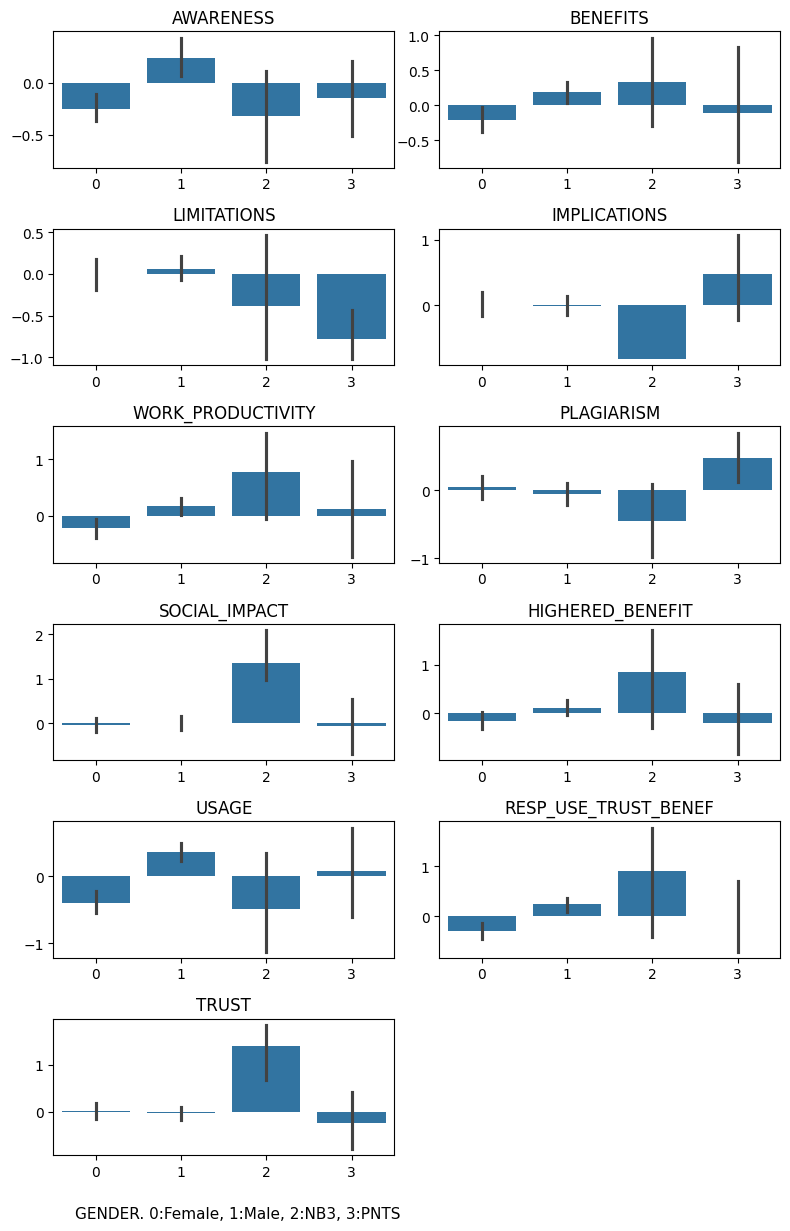

In [26]:
# Define the list of variables
variables = ['AWARENESS', 'BENEFITS', 'LIMITATIONS', 'IMPLICATIONS',
             'WORK_PRODUCTIVITY', 'PLAGIARISM', 'SOCIAL_IMPACT',
             'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST']

categorical_var_name='GENDER'
categorical_var_ordered_values = ['Female', 'Male', 'NB3', 'PNTS']


num_rows = 6
num_cols = 2

create_bar_graphs(categorical_var_name,categorical_var_ordered_values, variables, num_rows, num_cols, figsize=(8,12))

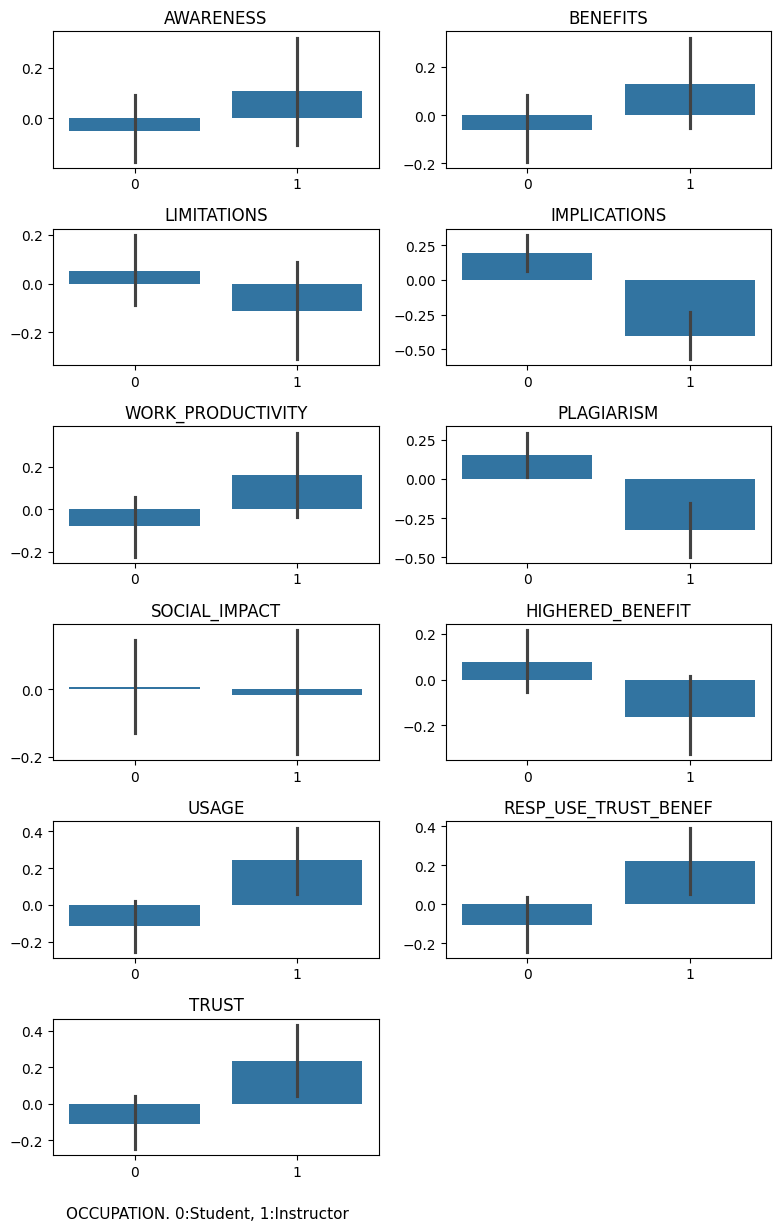

In [27]:
# Define the list of variables
variables = ['AWARENESS', 'BENEFITS', 'LIMITATIONS', 'IMPLICATIONS',
             'WORK_PRODUCTIVITY', 'PLAGIARISM', 'SOCIAL_IMPACT',
             'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST']

categorical_var_name='OCCUPATION'
categorical_var_ordered_values = ['Student', 'Instructor']

num_rows = 6
num_cols = 2

create_bar_graphs(categorical_var_name,categorical_var_ordered_values, variables, num_rows, num_cols, figsize=(8,12))

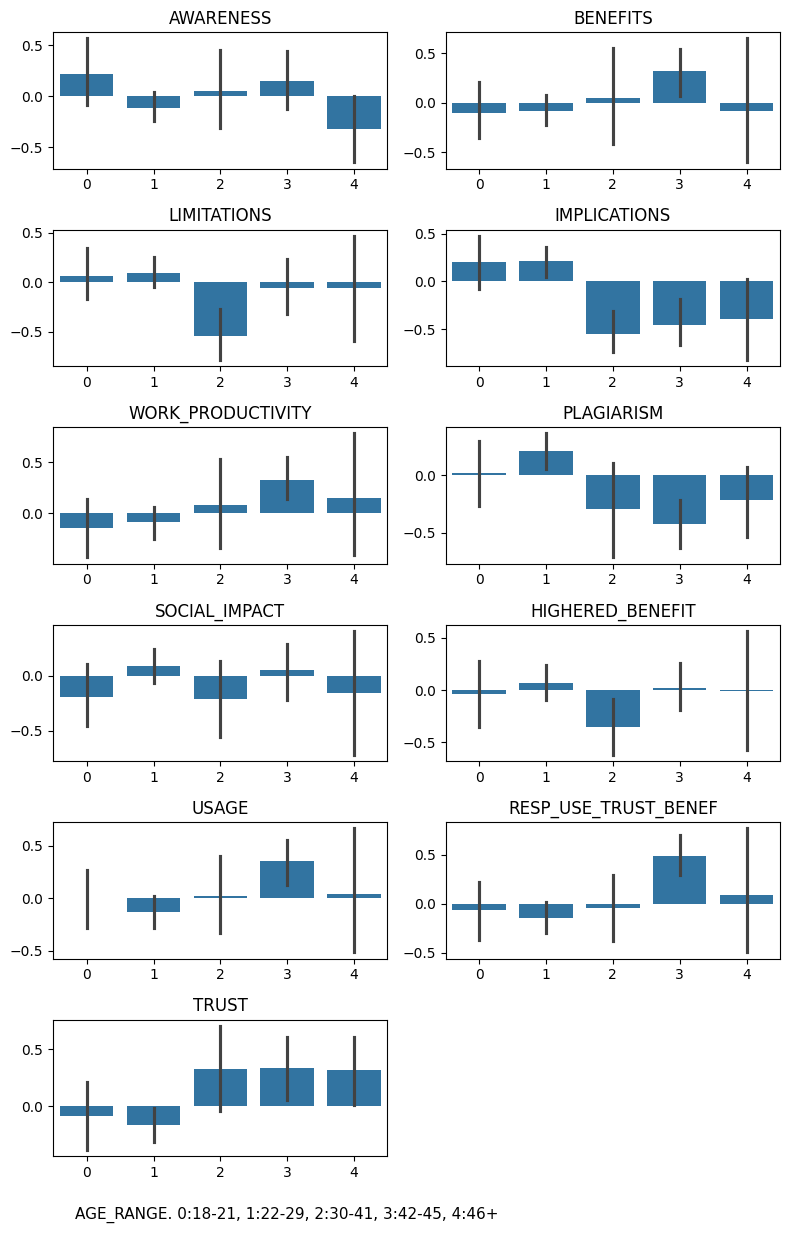

In [28]:
# Define the list of variables
variables = ['AWARENESS', 'BENEFITS', 'LIMITATIONS', 'IMPLICATIONS',
             'WORK_PRODUCTIVITY', 'PLAGIARISM', 'SOCIAL_IMPACT',
             'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST']

categorical_var_name='AGE_RANGE'
categorical_var_ordered_values = ['18-21', '22-29', '30-41', '42-45', '46+']

num_rows = 6
num_cols = 2

create_bar_graphs(categorical_var_name,categorical_var_ordered_values, variables, num_rows, num_cols, figsize=(8,12))

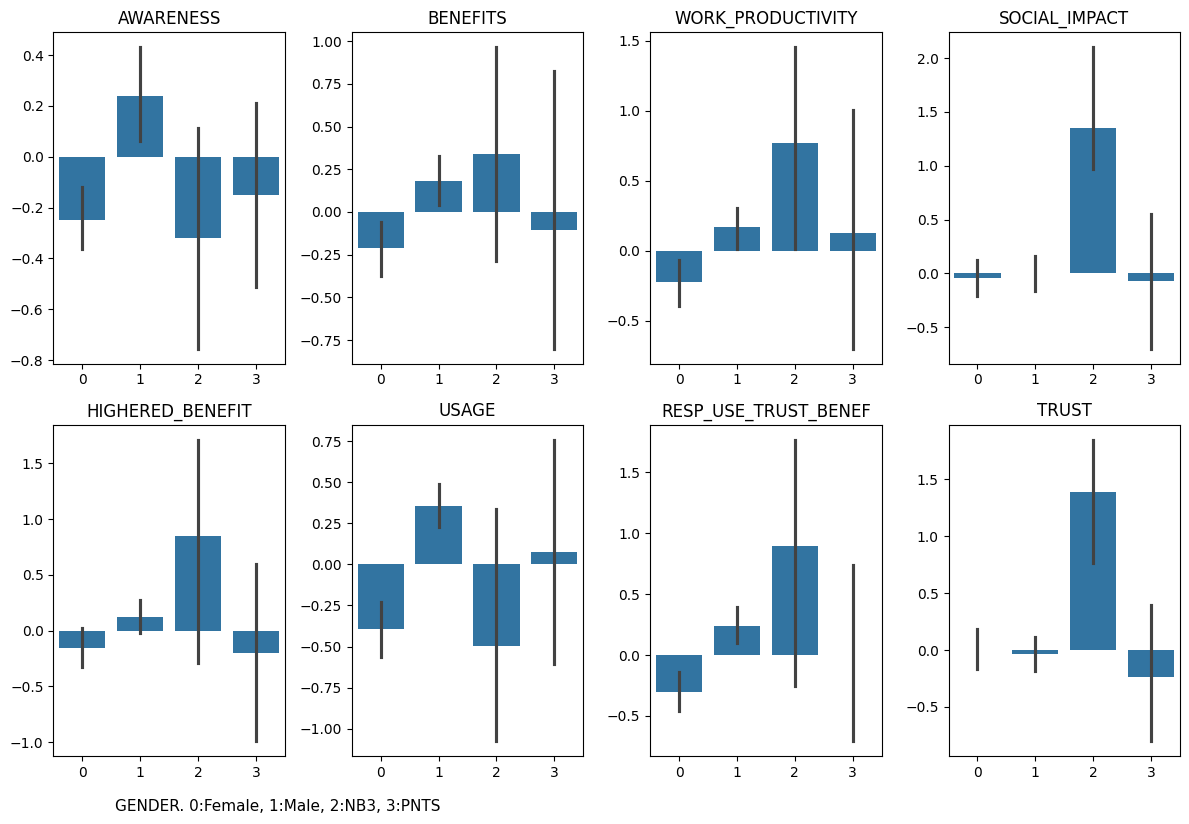

In [29]:
# Define the list of variables that are significant
variables = ['AWARENESS', 'BENEFITS', 'WORK_PRODUCTIVITY', 'SOCIAL_IMPACT',
             'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST']

categorical_var_name='GENDER'
categorical_var_ordered_values = ['Female', 'Male', 'NB3', 'PNTS']

num_rows = 2
num_cols = 4

create_bar_graphs(categorical_var_name,categorical_var_ordered_values, variables, num_rows, num_cols, figsize=(12,8))

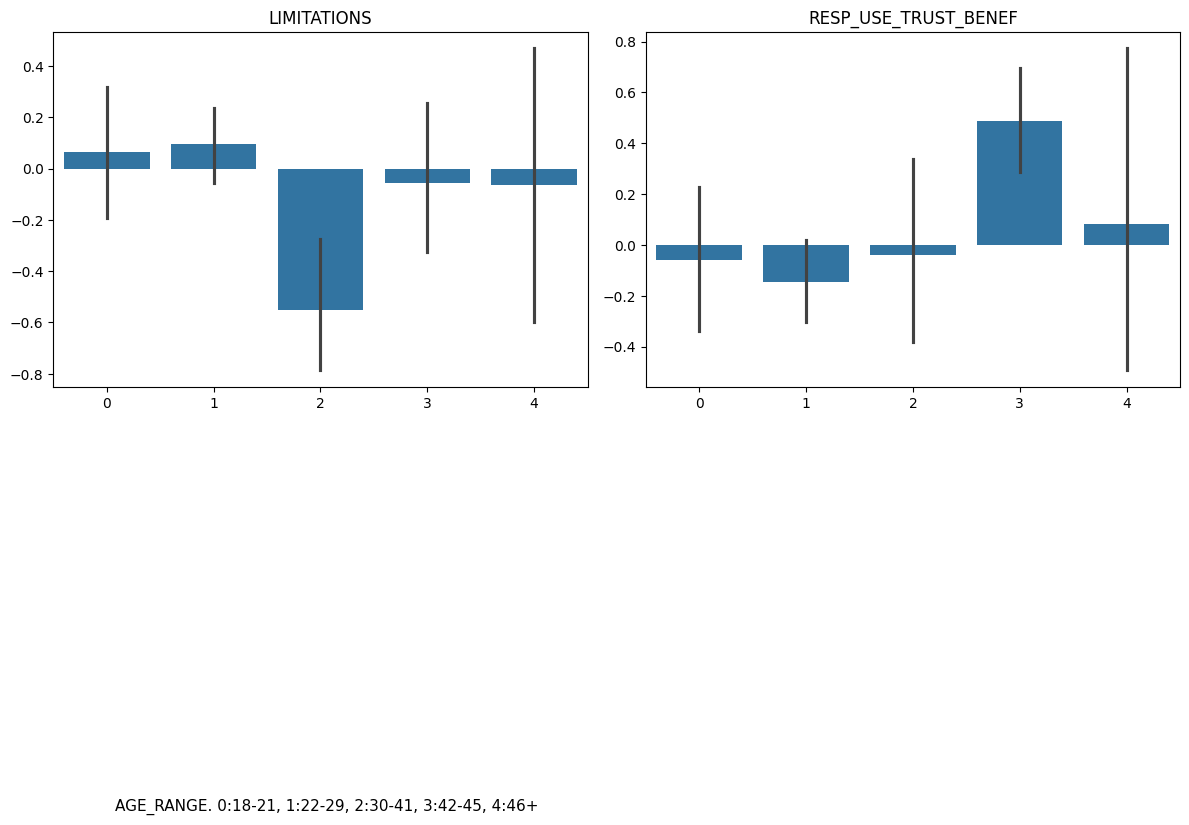

In [30]:
# Define the list of variables that are significant
variables = [ 'LIMITATIONS','RESP_USE_TRUST_BENEF']

categorical_var_name='AGE_RANGE'
categorical_var_ordered_values = ['18-21', '22-29', '30-41', '42-45', '46+']

num_rows = 2
num_cols = 2

create_bar_graphs(categorical_var_name,categorical_var_ordered_values, variables, num_rows, num_cols, figsize=(12,8))

___________________________________________

# Multiple regression and ANOVA
- 'AWARENESS'
- 'REASON_STUDENT'
- 'REASON_PROFESSIONAL'
- 'BENEFITS'
- 'LIMITATIONS'
- 'IMPLICATIONS'
- 'WORK_PRODUCTIVITY'
- 'PLAGIARISM'
- 'SOCIAL_IMPACT'
- 'HIGHERED_BENEFIT'
- 'USAGE'
- 'RESP_USE_TRUST_BENEF'
- 'ACCURACY'
- 'TRUST'

In [31]:
target_name = 'PLAGIARISM'

**Build OLS regression model without interactions**

In [32]:
import statsmodels.formula.api as smf

formula = f"{target_name} ~  C(AGE_RANGE) + C(OCCUPATION) + C(GENDER)"
print(formula)

# Fit the OLS regression model
lm = smf.ols(formula=formula, data=result_df).fit()

# Print the summary of the model
print(lm.summary())

#-----------------------------------------------------------
# Extract the significant coefficents
summary_text = lm.summary().as_text()

# Split the summary into lines
summary_lines = summary_text.split('\n')


# Initialize a list to store the significant lines
significant_lines = []

# Iterate through the summary lines and check for significance (typically p-value < 0.05)
for line in summary_lines:
    if  'coef' in line:
      significant_lines.append(line)
    elif 'Intercept' in line or 'C(AGE_RANGE)' in line or 'C(OCCUPATION)' in line or 'C(GENDER)' in line:
        p_value = float(line.split()[4])  # Assuming the p-value is in the 4th column
        if p_value < 0.05:
            significant_lines.append(line)

# Print the significant lines
print ("\nSignificant Main effects:")
print ("-----------------------------------------")
for line in significant_lines:
    print(line)

PLAGIARISM ~  C(AGE_RANGE) + C(OCCUPATION) + C(GENDER)
                            OLS Regression Results                            
Dep. Variable:             PLAGIARISM   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     2.968
Date:                Wed, 24 Jan 2024   Prob (F-statistic):            0.00329
Time:                        15:51:16   Log-Likelihood:                -416.75
No. Observations:                 302   AIC:                             851.5
Df Residuals:                     293   BIC:                             884.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

-------------------------------------
# Analysis of Variance

In [33]:
# In case we are interested in comparing  regular Ols and ols wih interactions
#-----------------------------------------------------------------------------
#from statsmodels.formula.api import ols
#from statsmodels.graphics.api import interaction_plot, abline_plot
#from statsmodels.stats.anova import anova_lm

#from statsmodels.stats.api import anova_lm

#table1 = anova_lm(lm, inter_OG_lm,inter_AO_lm,inter_AG_lm)
#print(table1)

## One-way Anova

In [34]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import MultiComparison

# Define the list of variables
variables = ['AWARENESS', 'BENEFITS', 'LIMITATIONS', 'IMPLICATIONS',
             'WORK_PRODUCTIVITY', 'PLAGIARISM', 'SOCIAL_IMPACT',
             'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST']
factors = ['AGE_RANGE' , 'GENDER' , 'OCCUPATION']
for factor_name in factors:
 for target_name in variables:
  # One-way ANOVA
  formula = f"{target_name} ~ C({factor_name})"
  print(formula)
  # Perform the ANOVA
  model = sm.formula.ols(formula, data=result_df).fit()
  anova_table = sm.stats.anova_lm(model, typ=2)

  # Perform Tukey's HSD test
  mc = MultiComparison(result_df[target_name], result_df[factor_name])
  tukey_result = mc.tukeyhsd()

  print("ANOVA Results:")
  print(anova_table)

  print("Tukey's HSD Test Results:")
  print(tukey_result)

AWARENESS ~ C(AGE_RANGE)
ANOVA Results:
                  sum_sq     df         F    PR(>F)
C(AGE_RANGE)    6.804318    4.0  1.711477  0.147359
Residual      295.195682  297.0       NaN       NaN
Tukey's HSD Test Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 18-21  22-29   0.3326 0.2407 -0.1107  0.776  False
 18-21  30-41   0.1597 0.9391 -0.4096  0.729  False
 18-21  42-45  -0.2104  0.967 -1.1024 0.6815  False
 18-21    46+   0.2635  0.441 -0.1642 0.6912  False
 22-29  30-41   -0.173 0.9502 -0.8265 0.4805  False
 22-29  42-45  -0.5431 0.5162  -1.491 0.4048  False
 22-29    46+  -0.0691 0.9966 -0.6038 0.4655  False
 30-41  42-45  -0.3701 0.8539  -1.383 0.6428  False
 30-41    46+   0.1039  0.992 -0.5391 0.7469  False
 42-45    46+    0.474 0.6391 -0.4667 1.4146  False
---------------------------------------------------
BENEFITS ~ C(AGE_RANGE)
ANOVA Results:
           

## 3-way ANOVA - Main Effects

In [35]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import MultiComparison #, pairwise_tukeyhsd

# Define the list of variables
variables = ['AWARENESS', 'BENEFITS', 'LIMITATIONS', 'IMPLICATIONS',
             'WORK_PRODUCTIVITY', 'PLAGIARISM', 'SOCIAL_IMPACT',
             'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST']

# Define the factors
factors = ['AGE_RANGE', 'GENDER', 'OCCUPATION']

for target_name in variables:
    # Multi-way ANOVA
    formula = f"{target_name} ~ C(AGE_RANGE) + C(GENDER) + C(OCCUPATION)"
    print(formula)

    # Perform the multi-way ANOVA
    model = sm.formula.ols(formula, data=result_df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    print(f"Multi-way ANOVA Results:")
    print(anova_table)

    # Perform Tukey's HSD for pairwise comparisons for each factor
    for factor in factors:
        mc = MultiComparison(result_df[target_name], result_df[factor])
        result = mc.tukeyhsd()

        print(f"Tukey's HSD Results for {factor}:")
        print(result)



AWARENESS ~ C(AGE_RANGE) + C(GENDER) + C(OCCUPATION)
Multi-way ANOVA Results:
                   sum_sq     df         F    PR(>F)
C(AGE_RANGE)     4.544754    4.0  1.194476  0.313318
C(GENDER)       16.366730    3.0  5.735455  0.000796
C(OCCUPATION)    0.042431    1.0  0.044608  0.832874
Residual       278.702215  293.0       NaN       NaN
Tukey's HSD Results for AGE_RANGE:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 18-21  22-29   0.3326 0.2407 -0.1107  0.776  False
 18-21  30-41   0.1597 0.9391 -0.4096  0.729  False
 18-21  42-45  -0.2104  0.967 -1.1024 0.6815  False
 18-21    46+   0.2635  0.441 -0.1642 0.6912  False
 22-29  30-41   -0.173 0.9502 -0.8265 0.4805  False
 22-29  42-45  -0.5431 0.5162  -1.491 0.4048  False
 22-29    46+  -0.0691 0.9966 -0.6038 0.4655  False
 30-41  42-45  -0.3701 0.8539  -1.383 0.6428  False
 30-41    46+   0.1039  0.992 -0.5391 0.7469  Fals

## 3-way ANOVA - Main Effects and Interactions

In [36]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import MultiComparison #, pairwise_tukeyhsd

# Define the list of variables
variables = ['AWARENESS', 'BENEFITS', 'LIMITATIONS', 'IMPLICATIONS',
             'WORK_PRODUCTIVITY', 'PLAGIARISM', 'SOCIAL_IMPACT',
             'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST']

# Define the factors
factors = ['AGE_RANGE', 'GENDER', 'OCCUPATION']

for target_name in variables:
    # Multi-way ANOVA
    formula = f"{target_name} ~ C(AGE_RANGE) * C(GENDER) * C(OCCUPATION)"
    print(formula)

    # Perform the multi-way ANOVA
    model = sm.formula.ols(formula, data=result_df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    print(f"Multi-way ANOVA Results:")
    print(anova_table)

    # Perform Tukey's HSD for pairwise comparisons for each factor
    for factor in factors:
        mc = MultiComparison(result_df[target_name], result_df[factor])
        result = mc.tukeyhsd()

        print(f"Tukey's HSD Results for {factor}:")
        print(result)



AWARENESS ~ C(AGE_RANGE) * C(GENDER) * C(OCCUPATION)
Multi-way ANOVA Results:
                                          sum_sq     df         F    PR(>F)
C(AGE_RANGE)                                 NaN    4.0       NaN       NaN
C(GENDER)                                    NaN    3.0       NaN       NaN
C(OCCUPATION)                                NaN    1.0       NaN       NaN
C(AGE_RANGE):C(GENDER)                  8.009611   12.0  0.709432  0.586066
C(AGE_RANGE):C(OCCUPATION)                   NaN    4.0       NaN       NaN
C(GENDER):C(OCCUPATION)                 0.485354    3.0  0.171956  0.678698
C(AGE_RANGE):C(GENDER):C(OCCUPATION)   10.730618   12.0  0.950438  0.448759
Residual                              262.496630  279.0       NaN       NaN
Tukey's HSD Results for AGE_RANGE:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 18-21  22-29   0.3326 0.2407 -0.1107  0.776  F

# Ordinal Logistic Regression (originally reported)

In [37]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from scipy.stats import chi2

variables = ['AWARENESS', 'BENEFITS', 'LIMITATIONS', 'IMPLICATIONS',
             'WORK_PRODUCTIVITY', 'PLAGIARISM', 'SOCIAL_IMPACT',
             'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST','AGE_RANGE', 'GENDER', 'OCCUPATION']
dfolr= result_df[variables]

# Create a DataFrame

dfolr['GENDER']=pd.Categorical(dfolr['GENDER'], categories=['Female', 'Male', 'NB3', 'PNTS'], ordered=False).codes
dfolr['OCCUPATION'] = pd.Categorical(dfolr['OCCUPATION'], categories=['Student','Instructor'], ordered=False).codes
dfolr['AGE_RANGE']=pd.Categorical(dfolr['AGE_RANGE'], categories=['18-21', '22-29', '30-41', '42-45', '46+'], ordered=True).codes

# Prepare the data for modeling
X = dfolr[['AWARENESS', 'BENEFITS', 'LIMITATIONS', 'IMPLICATIONS',
           'WORK_PRODUCTIVITY', 'PLAGIARISM', 'SOCIAL_IMPACT',
           'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST',
           'GENDER', 'OCCUPATION']]  # Predictor variables
#X = sm.add_constant(X)  # Adding a constant (intercept term)
y = dfolr['AGE_RANGE']  # Response variable

# Fit the Ordinal Logistic Regression Model
model = OrderedModel(y, X, distr='logit')
result = model.fit(method='bfgs')

# Summary of the model
print(result.summary())

# Calculate the odds ratios
params = result.params
odds_ratios = np.exp(params)

# Create a new DataFrame for the summary, including the odds ratios
summary_df = pd.DataFrame({
    'coef': params,
    'std err': result.bse,
    'z': result.tvalues,
    'P>|z|': result.pvalues,
    'odds_ratio': odds_ratios
    #'[0.025': result.conf_int()[0],
    #'0.975]': result.conf_int()[1]
})

print("Summary table with odds ratios:")
print(summary_df)


# Wald Chi-squared test
df_wald = X.shape[1]  # degrees of freedom is the number of predictor variables
wald_test_statistic = sum(result.tvalues[:df_wald]**2)
p_value_wald = 1 - chi2.cdf(wald_test_statistic, df_wald)
print(f"Wald chi-squared test statistic: {wald_test_statistic}")
print(f"Wald chi-squared test p-value: {p_value_wald}")

# McKelvey & Zavoina's R-squared
pred_prob = result.predict()
mu_y = np.mean(pred_prob, axis=0)
R2_MZ = np.var(np.dot(X, result.params[:X.shape[1]])) / (np.var(np.dot(X, result.params[:X.shape[1]])) + sum(mu_y*(1-mu_y)))
print(f"McKelvey & Zavoina's R2: {R2_MZ}")

# Making predictions (probabilities)
#predictions_proba = result.predict()

# Converting probabilities to predicted classes
#predicted_classes = np.argmax(predictions_proba, axis=1)

# Adding predicted classes to the DataFrame
#dfolr['predicted_class'] = predicted_classes

#print(dfolr.head())



Optimization terminated successfully.
         Current function value: 0.835457
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
                             OrderedModel Results                             
Dep. Variable:              AGE_RANGE   Log-Likelihood:                -252.31
Model:                   OrderedModel   AIC:                             538.6
Method:            Maximum Likelihood   BIC:                             601.7
Date:                Wed, 24 Jan 2024                                         
Time:                        15:51:53                                         
No. Observations:                 302                                         
Df Residuals:                     285                                         
Df Model:                          13                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------

In [38]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from scipy.stats import chi2

variables = ['AWARENESS', 'BENEFITS', 'LIMITATIONS', 'IMPLICATIONS',
             'WORK_PRODUCTIVITY', 'PLAGIARISM', 'SOCIAL_IMPACT',
             'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST','AGE_RANGE', 'GENDER', 'OCCUPATION']
dfolr= result_df[variables]

# Create a DataFrame

dfolr['GENDER']=pd.Categorical(dfolr['GENDER'], categories=['Female', 'Male', 'NB3', 'PNTS'], ordered=False).codes
dfolr['OCCUPATION'] = pd.Categorical(dfolr['OCCUPATION'], categories=['Student','Instructor'], ordered=False).codes
dfolr['AGE_RANGE']=pd.Categorical(dfolr['AGE_RANGE'], categories=['18-21', '22-29', '30-41', '42-45', '46+'], ordered=True).codes

# Prepare the data for modeling
X = dfolr[['AWARENESS', 'BENEFITS', 'LIMITATIONS', 'IMPLICATIONS',
           'WORK_PRODUCTIVITY', 'PLAGIARISM', 'SOCIAL_IMPACT',
           'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST',
           'GENDER', 'OCCUPATION']]  # Predictor variables
#X = sm.add_constant(X)  # Adding a constant (intercept term)
y = dfolr['AGE_RANGE']  # Response variable

# Fit the Ordinal Logistic Regression Model
model = OrderedModel(y, X, distr='logit')
result = model.fit(method='bfgs')

# Summary of the model
print(result.summary())

# Calculate the odds ratios
params = result.params
odds_ratios = np.exp(params)

# Create a new DataFrame for the summary, including the odds ratios
summary_df = pd.DataFrame({
    'coef': params,
    'std err': result.bse,
    'z': result.tvalues,
    'P>|z|': result.pvalues,
    'odds_ratio': odds_ratios
    #'[0.025': result.conf_int()[0],
    #'0.975]': result.conf_int()[1]
})

print("Summary table with odds ratios:")
print(summary_df)


# Wald Chi-squared test
df_wald = X.shape[1]  # degrees of freedom is the number of predictor variables
wald_test_statistic = sum(result.tvalues[:df_wald]**2)
p_value_wald = 1 - chi2.cdf(wald_test_statistic, df_wald)
print(f"Wald chi-squared test statistic: {wald_test_statistic}")
print(f"Wald chi-squared test p-value: {p_value_wald}")

# McKelvey & Zavoina's R-squared
pred_prob = result.predict()
mu_y = np.mean(pred_prob, axis=0)
R2_MZ = np.var(np.dot(X, result.params[:X.shape[1]])) / (np.var(np.dot(X, result.params[:X.shape[1]])) + sum(mu_y*(1-mu_y)))
print(f"McKelvey & Zavoina's R2: {R2_MZ}")

# Making predictions (probabilities)
#predictions_proba = result.predict()

# Converting probabilities to predicted classes
#predicted_classes = np.argmax(predictions_proba, axis=1)

# Adding predicted classes to the DataFrame
#dfolr['predicted_class'] = predicted_classes

#print(dfolr.head())



Optimization terminated successfully.
         Current function value: 0.835457
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
                             OrderedModel Results                             
Dep. Variable:              AGE_RANGE   Log-Likelihood:                -252.31
Model:                   OrderedModel   AIC:                             538.6
Method:            Maximum Likelihood   BIC:                             601.7
Date:                Wed, 24 Jan 2024                                         
Time:                        15:51:54                                         
No. Observations:                 302                                         
Df Residuals:                     285                                         
Df Model:                          13                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------

## Logistic Regression

In [54]:
X.loc[(X['GENDER']== 'Female') | (X['GENDER']=='Male') ].head()

,AWARENESS,BENEFITS,LIMITATIONS,IMPLICATIONS,WORK_PRODUCTIVITY,PLAGIARISM,SOCIAL_IMPACT,HIGHERED_BENEFIT,USAGE,RESP_USE_TRUST_BENEF,TRUST,AGE_RANGE,GENDER
0,-0.755298,2.218365,2.175334,2.377914,0.937114,-1.743006,0.971289,1.710593,0.986605,1.999262,1.945316,22-29,Male
1,0.330892,-0.917109,-1.024102,-0.823260,-0.958130,-0.087859,-0.909027,-1.151452,-0.827791,-0.711531,-0.762243,18-21,Male
2,0.330892,-0.917109,0.042377,0.243798,-0.780467,-0.749158,0.971289,-1.151452,-0.744877,-0.991761,-0.762243,18-21,Female
3,-0.755298,-0.917109,-1.024102,-0.823260,-0.395364,-0.485240,0.971289,0.279571,-1.449064,-0.917453,-0.762243,18-21,Female
4,2.503273,-0.917109,0.042377,0.243798,-0.188417,0.951111,-0.909027,-1.151452,0.986605,-0.817471,-1.248278,18-21,Female


In [62]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import chi2


variables = ['AWARENESS', 'BENEFITS', 'LIMITATIONS', 'IMPLICATIONS',
             'WORK_PRODUCTIVITY', 'PLAGIARISM', 'SOCIAL_IMPACT',
             'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST','AGE_RANGE', 'GENDER', 'OCCUPATION']

X = result_df[variables].drop('OCCUPATION', axis=1)
X=X.loc[(X['GENDER']== 'Female') | (X['GENDER']=='Male') ].head()
#y=pd.Categorical(result_df['AGE_RANGE'], categories=['18-21', '22-29', '30-41', '42-45', '46+'], ordered=True).codes

# Preprocessing: Create categorical codes for the 'GENDER' and 'AGE_RANGE' columns
X = pd.get_dummies(X,drop_first=True)
y=X['GENDER_Male']
X=X.drop('GENDER_Male', axis=1)
X.head(20)

,AWARENESS,BENEFITS,LIMITATIONS,IMPLICATIONS,WORK_PRODUCTIVITY,PLAGIARISM,SOCIAL_IMPACT,HIGHERED_BENEFIT,USAGE,RESP_USE_TRUST_BENEF,TRUST,AGE_RANGE_22-29
0,-0.755298,2.218365,2.175334,2.377914,0.937114,-1.743006,0.971289,1.710593,0.986605,1.999262,1.945316,1
1,0.330892,-0.917109,-1.024102,-0.823260,-0.958130,-0.087859,-0.909027,-1.151452,-0.827791,-0.711531,-0.762243,0
2,0.330892,-0.917109,0.042377,0.243798,-0.780467,-0.749158,0.971289,-1.151452,-0.744877,-0.991761,-0.762243,0
3,-0.755298,-0.917109,-1.024102,-0.823260,-0.395364,-0.485240,0.971289,0.279571,-1.449064,-0.917453,-0.762243,0
4,2.503273,-0.917109,0.042377,0.243798,-0.188417,0.951111,-0.909027,-1.151452,0.986605,-0.817471,-1.248278,0


In [63]:
# Add constant term
X = sm.add_constant(X)

# Fit the model
# Fit the Ordinal Logistic Regression Model
model = sm.Logit(y, X)
result = model.fit(method='newton')
print(result.summary())

# Calculate the odds ratios
params = result.params
odds_ratios = np.exp(params)

# Create a new DataFrame for the summary, including the odds ratios
summary_df = pd.DataFrame({
    'coef': params,
    'std err': result.bse,
    'z': result.tvalues,
    'P>|z|': result.pvalues,
    'odds_ratio': odds_ratios
    #'[0.025': result.conf_int()[0],
    #'0.975]': result.conf_int()[1]
})

print("Summary table with odds ratios:")
print(summary_df)

# Manually calculate Wald Test
wald_test_statistic = np.sum(np.square(result.tvalues.values))
df_wald = np.prod(result.params.shape)  # degrees of freedom, based on the number of coefficients
p_value_wald = 1 - chi2.cdf(wald_test_statistic, df_wald)
print(f"Wald chi-squared test statistic: {wald_test_statistic}")
print(f"Wald chi-squared test p-value: {p_value_wald}")


         Current function value: inf
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:            GENDER_Male   No. Observations:                    5
Model:                          Logit   Df Residuals:                        1
Method:                           MLE   Df Model:                            3
Date:                Wed, 24 Jan 2024   Pseudo R-squ.:                     inf
Time:                        16:43:39   Log-Likelihood:                   -inf
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.9389        nan        nan        nan         nan         nan
AWARENESS               -6.0276        n

In [ ]:
X.info()